# Sea Surface Temperature — NEMO GYRE

Analyse SST (`sosstsst`) from the GYRE simulation.
- Mean SST field
- SST temporal evolution
- Meridional SST gradient

In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import nc_time_axis  # noqa: F401 — registers cftime support in matplotlib

from gyre import load_output, load_mesh, interior_mask, cell_area, gyre_map

plt.rcParams.update({"font.size": 16, "axes.titlesize": 18, "axes.labelsize": 14})

OUTPUT_DIR = Path("../output")

## Load simulation output

Load the recombined grid_T file and mesh_mask. Cell widths `e1t`/`e2t`
provide area weighting for spatial averages, and `tmask` masks land
and boundary cells.

In [2]:
ds = load_output("*_grid_T.nc", OUTPUT_DIR)
mesh = load_mesh(OUTPUT_DIR)

interior = interior_mask(mesh.tmask.isel(nav_lev=0))
area = cell_area(mesh)
e1t = mesh["e1t"]

sst = ds["sosstsst"]
sst

/gxfs_work/geomar/smomw122/2026-Claude-NEMO/analysis/gyre.py:48: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(files, decode_cf=False, chunks=-1)


<xarray.DataArray 'sosstsst' (time_counter: 2124, y: 102, x: 152)> Size: 132MB
array([[[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      , 23.122063, 23.15244 , ..., 23.186413, 23.209312,
          0.      ],
        [ 0.      , 23.146036, 23.214073, ..., 23.05841 , 23.108297,
          0.      ],
        ...,
        [ 0.      , 23.168423, 23.18114 , ..., 22.90347 , 23.024343,
          0.      ],
        [ 0.      , 23.1553  , 23.157295, ..., 23.039999, 23.094946,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      , 22.603157, 22.578049, ..., 22.926565, 22.99624 ,
          0.      ],
        [ 0.      , 22.675611, 22.828596, ..., 22.88784 , 22.99607 ,
          0.      ],
...
        [ 0.      , 20.8353  , 20.877535, ..., 16.488047, 16.520441,
          0.      ],
        [ 0.      , 20.820164, 20.822071, ..., 16.507504, 16.520159,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]],

       [[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ],
        [ 0.      , 20.35425 , 20.444155, ..., 17.842304, 17.840883,
          0.      ],
        [ 0.      , 20.491644, 20.627573, ..., 17.820301, 17.820335,
          0.      ],
        ...,
        [ 0.      , 20.865984, 20.9001  , ..., 16.488995, 16.542645,
          0.      ],
        [ 0.      , 20.850452, 20.860622, ..., 16.524843, 16.541712,
          0.      ],
        [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
          0.      ]]], shape=(2124, 102, 152), dtype=float32)
Coordinates:
  * time_counter  (time_counter) float64 17kB 4.32e+05 1.296e+06 ... 1.835e+09
  * y             (y) int64 816B 0 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100 101
  * x             (x) int64 1kB 0 1 2 3 4 5 6 7 ... 145 146 147 148 149 150 151
Attributes:
    units:               C
    standard_name:       Sea Surface temperature
    _FillValue:          9.96921e+36
    long_name:           Sea Surface temperature
    online_operation:    ave(x)
    interval_operation:  2880.0
    interval_write:      864000.0
    coordinates:         time_counter nav_lat nav_lon

## Time-mean SST

Average SST over the full simulation.

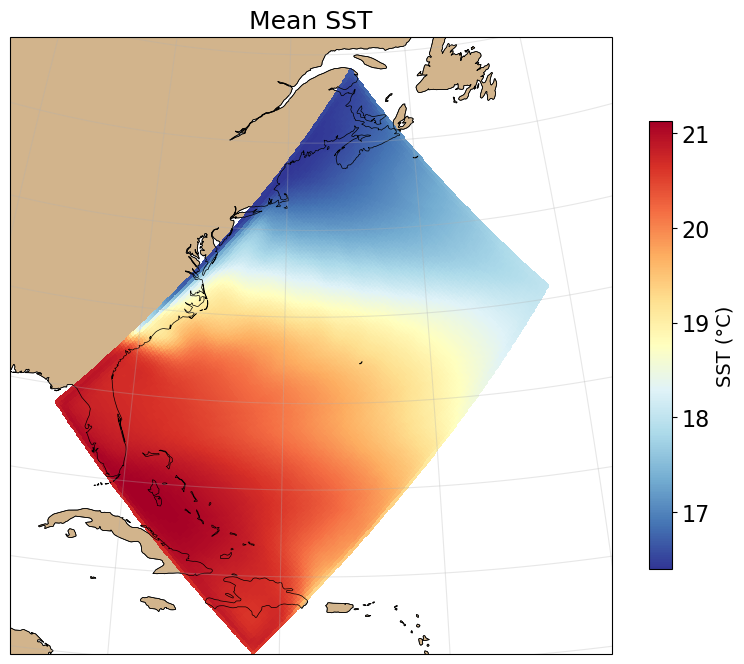

In [3]:
sst_mean = sst.mean("time_counter").where(interior)

fig, ax = gyre_map(ds=ds)

pcm = ax.pcolormesh(
    ds.nav_lon.values, ds.nav_lat.values, sst_mean.values,
    shading="auto", cmap="RdYlBu_r", transform=ccrs.PlateCarree(),
)
fig.colorbar(pcm, ax=ax, label="SST (°C)", shrink=0.7)
ax.set_title("Mean SST")
fig.tight_layout()
fig.savefig("../figures/sst_mean.png", dpi=150, bbox_inches="tight")

## SST temporal evolution

Area-weighted domain-mean SST over time.

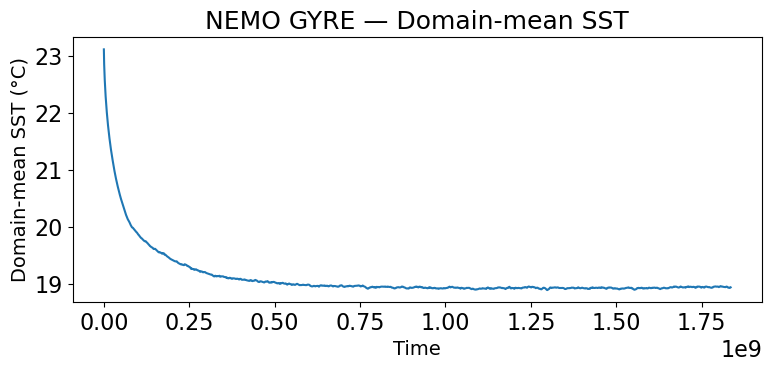

In [4]:
weights = area * interior
sst_domain_mean = sst.weighted(weights).mean(["y", "x"])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(sst_domain_mean.time_counter, sst_domain_mean)
ax.set_xlabel("Time")
ax.set_ylabel("Domain-mean SST (°C)")
ax.set_title("NEMO GYRE — Domain-mean SST")
fig.tight_layout()

## Meridional SST gradient

Zonal-mean SST as a function of latitude, weighted by cell width `e1t`.

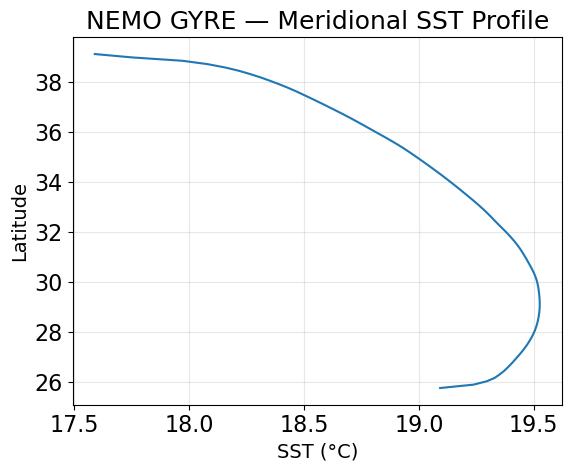

In [5]:
sst_time_mean = sst.mean("time_counter").where(interior)
sst_zonal = sst_time_mean.weighted(e1t).mean("x")

# Representative latitude for each y-row (mid-column value)
lat_1d = ds.nav_lat.isel(x=ds.sizes["x"] // 2)

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(sst_zonal, lat_1d)
ax.set_xlabel("SST (°C)")
ax.set_ylabel("Latitude")
ax.set_title("NEMO GYRE — Meridional SST Profile")
ax.grid(True, alpha=0.3)
fig.tight_layout()